In [1]:
# Import the required libraries.

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import datetime as dt
import os
import scipy.stats
from itertools import combinations
import gmplot 
from itertools import combinations

from sklearn import manifold
from sklearn.metrics.pairwise import haversine_distances
from math import radians

In [2]:
# Read in the processed csv file created during data wrangling phase of project.

dataset=pd.read_csv('C:/Users/andre/Desktop/citibiki-data-tocluster.csv')

In [3]:
# Convert the 'starttime' and 'stoptime' columns to datetime format.

dataset['starttime'] = dataset.loc[:,'starttime'].apply(lambda x:dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f'))
dataset['stoptime'] = dataset.loc[:,'stoptime'].apply(lambda x:dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f'))

In [4]:
# Create a list of unique stations.

stations=dataset[['start station id','start station latitude','start station longitude']].copy()
stations.drop_duplicates(inplace=True)
stations.sort_values('start station id', ascending=True, inplace=True)
stations.reset_index(inplace=True)
stations.drop('index',axis=1,inplace=True)

In [5]:
# Create the coordinate list in radians 

xcoord=list(stations['start station latitude'])
ycoord=list(stations['start station longitude'])

xcoord_rad=[None]*822
ycoord_rad=[None]*822
coord_rad=[None]*822

for i in range(822):
    xcoord_rad[i]=radians(xcoord[i])
    ycoord_rad[i]=radians(ycoord[i])

for i in range(822):
    coord_rad[i]=[xcoord_rad[i],ycoord_rad[i]]

In [6]:
# Calculate pairwise Haversine distances and convert the distances to kilometers.

similarities=haversine_distances(coord_rad)
similarities=similarities * 6371000/1000  

In [7]:
# Multi-dimensional scaling to reduce the latitiude and longitude pairs for each station to one dimension.

mds= manifold.MDS(n_components=1, dissimilarity="precomputed")

pos = mds.fit(similarities).embedding_

In [8]:
# Normalize the station numbers and create a dictionary to use to assign these numbers to the dataset.

normalized = (pos-min(pos))/(max(pos)-min(pos))
normalized=pd.DataFrame(normalized)
stations['normalized']=normalized
normdict=stations[['start station id','normalized']].copy()
normdict=normdict.set_index('start station id')
normdict=normdict['normalized'].rename('start station id')
normdict=normdict.to_dict()

In [9]:
# Generate the data set for k-means clustering.

cdata=dataset[['start station id','end station id','starttime','stoptime','usertype','gender','age']].copy()

In [10]:
# Convert timestamps in 'starttime' and 'stoptime' to time of day in '%H:%M:%S' format.

cdata['start']=cdata['starttime'].dt.strftime("%H:%M:%S")

cdata['end']=cdata['stoptime'].dt.strftime("%H:%M:%S")

cdata['start'] = cdata.loc[:,'start'].apply(lambda x:dt.datetime.strptime(x,'%H:%M:%S'))
cdata['end'] = cdata.loc[:,'end'].apply(lambda x:dt.datetime.strptime(x,'%H:%M:%S'))

cdata.drop('starttime',axis=1,inplace=True)
cdata.drop('stoptime',axis=1,inplace=True)

In [11]:
# Convert 'start' and 'end' to seconds and then convert to 2-component sine and cosine representation. 

cdata['start']=cdata['start'].dt.hour*3600+cdata['start'].dt.minute*60+cdata['start'].dt.second
cdata['end']=cdata['end'].dt.hour*3600+cdata['end'].dt.minute*60+cdata['end'].dt.second

cdata['sin_start']=np.sin(2*np.pi*cdata['start']/(60*24*60))
cdata['cos_start']=np.cos(2*np.pi*cdata['start']/(60*24*60))

cdata['sin_end']=np.sin(2*np.pi*cdata['end']/(60*24*60))
cdata['cos_end']=np.cos(2*np.pi*cdata['end']/(60*24*60))

cdata.drop('start',axis=1,inplace=True)
cdata.drop('end',axis=1,inplace=True)

In [12]:
# Normalize the 'age' data.

cdata['age'] = (cdata['age']-min(cdata['age']))/(max(cdata['age'])-min(cdata['age']))

In [13]:
# Replace the 'start station id' and 'end station id' with the station location numbers obtained from MDS.

cdata['start station id']=cdata['start station id'].replace(to_replace = normdict, value=None)
cdata['end station id']=cdata['end station id'].replace(to_replace = normdict, value=None)

In [14]:
# Replace 'subscriber' with 1 and 'customer' with 0 in 'usertype' column.

utdict={'Subscriber':1,'Customer':0}
cdata['usertype']= cdata['usertype'].replace(to_replace = utdict, value=None)

In [15]:
# Set 'male' to 0 and 'female' to 1 in 'gender' column.

cdata['gender']=cdata['gender']-1

In [16]:
# rename 'station id' columns to reflect change to mds scaling

cdata.rename(columns={'start station id':'start station mds','end station id':'end station mds'}, inplace=True)

In [17]:
# Normalize the time component data.

cdata['sin_start'] = (cdata['sin_start']-min(cdata['sin_start']))/(max(cdata['sin_start'])-min(cdata['sin_start']))
cdata['cos_start'] = (cdata['cos_start']-min(cdata['cos_start']))/(max(cdata['cos_start'])-min(cdata['cos_start']))
cdata['sin_end'] = (cdata['sin_end']-min(cdata['sin_end']))/(max(cdata['sin_end'])-min(cdata['sin_end']))
cdata['cos_end'] = (cdata['cos_end']-min(cdata['cos_end']))/(max(cdata['cos_end'])-min(cdata['cos_end']))

In [18]:
cdata.head(10)

,start station mds,end station mds,usertype,gender,age,sin_start,cos_start,sin_end,cos_end
0,0.213261,0.151775,1,0,0.500000,0.503891,0.999985,0.515524,0.999759
1,0.367369,0.383536,1,0,0.609375,0.510289,0.999894,0.521810,0.999524
2,0.172045,0.232660,1,0,0.250000,0.513198,0.999826,0.534697,0.998795
3,0.470704,0.445795,1,0,0.203125,0.515378,0.999763,0.613255,0.987004
4,0.496578,0.442248,1,0,0.375000,0.516541,0.999726,0.527584,0.999239
5,0.936846,0.987395,1,1,0.218750,0.518649,0.999652,0.538069,0.998549
6,0.156725,0.190668,1,0,0.250000,0.520393,0.999584,0.530561,0.999065
7,0.461566,0.816882,1,0,0.343750,0.524788,0.999385,0.580730,0.993440
8,0.822011,0.818685,1,1,0.203125,0.526785,0.999282,0.537707,0.998576
9,0.501758,0.518781,1,0,0.250000,0.526858,0.999278,0.531359,0.999016


In [19]:
# Convert data set from a data frame to a matrix.

x_cols = cdata.as_matrix()
x_cols = np.nan_to_num(x_cols)
print(x_cols.shape)
print(cdata.shape)

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(8343761, 9)
(8343761, 9)


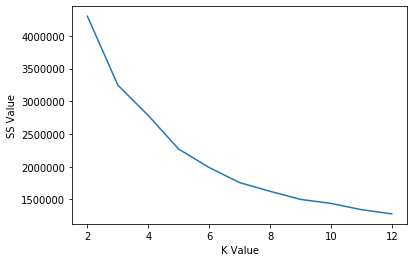

In [24]:
# K-Means Clustering for k = 2 to k = 12.

from sklearn.cluster import KMeans

k = [2,3,4,5,6,7,8,9,10,11,12]
assignment = np.zeros(shape=(11,8343761)) 
SS = np.zeros(shape=(11,1))

for i,b in enumerate(k):
    
    clusterer = KMeans(n_clusters=b, random_state=0)    
    cluster_labels = clusterer.fit_predict(x_cols)      
    assignment[i] = cluster_labels  
    SS[i] = clusterer.inertia_
    
    cluster=pd.DataFrame(assignment[i])
    cluster.columns=['cluster']
    cluster.to_csv('C:/Users/andre/Desktop/clusteredtime1/citibiki-20cluster-time{:.0f}.csv'.format(b), index=None)

    
plt.plot(k,SS)
plt.xlabel('K Value')
plt.ylabel('SS Value')
plt.show()

In [20]:
# SS   array([[4299496.48604893],
#       [3246852.17949386],
#       [2782319.09118183],
#       [2268683.48577036],
#       [1987595.44614007],
#       [1756947.03008148],
#       [1624281.1973039 ],
#       [1500621.7527961 ],
#       [1438904.7098616 ],
#       [1343963.44129468],
#       [1278474.09293443]])

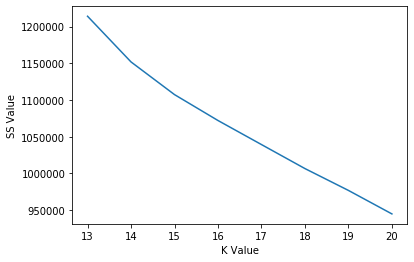

In [24]:
# K-Means Clustering for k = 13 to K = 20.

k = [13,14,15,16,17,18,19,20]
assignment = np.zeros(shape=(8,8343761)) 
SS = np.zeros(shape=(8,1))

for i,b in enumerate(k):
    
    clusterer = KMeans(n_clusters=b, random_state=0)    
    cluster_labels = clusterer.fit_predict(x_cols)      
    assignment[i] = cluster_labels  
    SS[i] = clusterer.inertia_
    
    cluster=pd.DataFrame(assignment[i])
    cluster.columns=['cluster']
    cluster.to_csv('C:/Users/andre/Desktop/clusteredtime1/citibiki-20cluster-time{:.0f}.csv'.format(b), index=None)
    
    ssvalue=pd.DataFrame(SS[i])
    ssvalue.columns=['ssvalue'] 
    ssvalue.to_csv('C:/Users/andre/Desktop/clusteredtime1/ssvalue{:.0f}.csv'.format(b), index=None)
    
plt.plot(k,SS)
plt.xlabel('K Value')
plt.ylabel('SS Value')
plt.show()

In [21]:
#SS   array([[1214052.22719098],
#       [1151812.8248686 ],
#       [1107307.15952047],
#       [1072014.06132739],
#       [1039251.35390012],
#       [1006537.10330636],
#       [ 976775.52557917],
#       [ 944770.7154258 ]])

In [22]:
SSfull =[4299496.48604893, 3246852.17949386, 2782319.09118183, 2268683.48577036, 1987595.44614007, 1756947.03008148, 1624281.1973039, \
1500621.7527961, 1438904.7098616, 1343963.44129468, 1278474.09293443, \
1214052.22719098, 1151812.8248686,1107307.15952047,1072014.06132739,1039251.35390012, 1006537.10330636, 976775.52557917, \
944770.7154258]

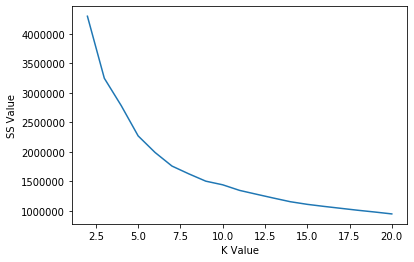

In [23]:
# SS plot for k =2 to k = 20.

kfull = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

plt.plot(kfull,SSfull)
plt.xlabel('K Value')
plt.ylabel('SS Value')
plt.show()

In [24]:
# clustering assignments were saved to .csv files as clustering from k=2 to k=20 takes over 14 hours hours and cannot be repeated
# every time the notebook is reset. This code reads the .csv files and assigns them to data frames.

cdata2=pd.read_csv('C:/Users/andre/Desktop/clusteredtime1/citibiki-20cluster-time2.csv')
cdata3=pd.read_csv('C:/Users/andre/Desktop/clusteredtime1/citibiki-20cluster-time3.csv')
cdata4=pd.read_csv('C:/Users/andre/Desktop/clusteredtime1/citibiki-20cluster-time4.csv')
cdata5=pd.read_csv('C:/Users/andre/Desktop/clusteredtime1/citibiki-20cluster-time5.csv')
cdata6=pd.read_csv('C:/Users/andre/Desktop/clusteredtime1/citibiki-20cluster-time6.csv')
cdata7=pd.read_csv('C:/Users/andre/Desktop/clusteredtime1/citibiki-20cluster-time7.csv')
cdata8=pd.read_csv('C:/Users/andre/Desktop/clusteredtime1/citibiki-20cluster-time8.csv')
cdata9=pd.read_csv('C:/Users/andre/Desktop/clusteredtime1/citibiki-20cluster-time9.csv')
cdata10=pd.read_csv('C:/Users/andre/Desktop/clusteredtime1/citibiki-20cluster-time10.csv')

cdata11=pd.read_csv('C:/Users/andre/Desktop/clusteredtime1/citibiki-20cluster-time11.csv')
cdata12=pd.read_csv('C:/Users/andre/Desktop/clusteredtime1/citibiki-20cluster-time12.csv')
cdata13=pd.read_csv('C:/Users/andre/Desktop/clusteredtime1/citibiki-20cluster-time13.csv')
cdata14=pd.read_csv('C:/Users/andre/Desktop/clusteredtime1/citibiki-20cluster-time14.csv')
cdata15=pd.read_csv('C:/Users/andre/Desktop/clusteredtime1/citibiki-20cluster-time15.csv')
cdata16=pd.read_csv('C:/Users/andre/Desktop/clusteredtime1/citibiki-20cluster-time16.csv')
cdata17=pd.read_csv('C:/Users/andre/Desktop/clusteredtime1/citibiki-20cluster-time17.csv')
cdata18=pd.read_csv('C:/Users/andre/Desktop/clusteredtime1/citibiki-20cluster-time18.csv')
cdata19=pd.read_csv('C:/Users/andre/Desktop/clusteredtime1/citibiki-20cluster-time19.csv')
cdata20=pd.read_csv('C:/Users/andre/Desktop/clusteredtime1/citibiki-20cluster-time20.csv')

In [25]:
# Re-create a data set that the cluster assignments for concatenation with the k-means cluster assignments.

cdata=dataset[['start station id','end station id','starttime','stoptime','usertype','gender','age']].copy()

cdata['start']=cdata['starttime'].dt.strftime("%H:%M:%S")
cdata['end']=cdata['stoptime'].dt.strftime("%H:%M:%S")

cdata['start'] = cdata.loc[:,'start'].apply(lambda x:dt.datetime.strptime(x,'%H:%M:%S').time())
cdata['end'] = cdata.loc[:,'end'].apply(lambda x:dt.datetime.strptime(x,'%H:%M:%S').time())

cdata['trip']=cdata['start station id'].map(str) +" to " + cdata['end station id'].map(str)

In [26]:
# merge clustering data frame with cluster assignments obtained from k-means clustering.

cdata2=pd.concat([cdata,cdata2], axis=1)
cdata3=pd.concat([cdata,cdata3], axis=1)
cdata4=pd.concat([cdata,cdata4], axis=1)
cdata5=pd.concat([cdata,cdata5], axis=1)
cdata6=pd.concat([cdata,cdata6], axis=1)
cdata7=pd.concat([cdata,cdata7], axis=1)
cdata8=pd.concat([cdata,cdata8], axis=1)
cdata9=pd.concat([cdata,cdata9], axis=1)
cdata10=pd.concat([cdata,cdata10], axis=1)

cdata11=pd.concat([cdata,cdata11], axis=1)
cdata12=pd.concat([cdata,cdata12], axis=1)
cdata13=pd.concat([cdata,cdata13], axis=1)
cdata14=pd.concat([cdata,cdata14], axis=1)
cdata15=pd.concat([cdata,cdata15], axis=1)
cdata16=pd.concat([cdata,cdata16], axis=1)
cdata17=pd.concat([cdata,cdata17], axis=1)
cdata18=pd.concat([cdata,cdata18], axis=1)
cdata19=pd.concat([cdata,cdata19], axis=1)
cdata20=pd.concat([cdata,cdata20], axis=1)

In [27]:
cdata2.head(5)

,start station id,end station id,starttime,stoptime,usertype,gender,age,start,end,trip,cluster
0,3160.0,3283.0,2019-01-01 00:01:47.401,2019-01-01 00:07:07.581,Subscriber,1,48,00:01:47,00:07:07,3160.0 to 3283.0,0.0
1,519.0,518.0,2019-01-01 00:04:43.736,2019-01-01 00:10:00.608,Subscriber,1,55,00:04:43,00:10:00,519.0 to 518.0,0.0
2,3171.0,3154.0,2019-01-01 00:06:03.997,2019-01-01 00:15:55.438,Subscriber,1,32,00:06:03,00:15:55,3171.0 to 3154.0,0.0
3,504.0,3709.0,2019-01-01 00:07:03.545,2019-01-01 00:52:22.650,Subscriber,1,29,00:07:03,00:52:22,504.0 to 3709.0,0.0
4,229.0,503.0,2019-01-01 00:07:35.945,2019-01-01 00:12:39.502,Subscriber,1,40,00:07:35,00:12:39,229.0 to 503.0,0.0


In [28]:
# Cluster Describe Function - Provides description of the clusters that have been produced for a given k value.

def clusterdescribe(k,df):
    
    n=list(range(k))                 

    for i,b in enumerate(n):
        
        cluster=df[df['cluster']==b]   
    
        cluster1=cluster['age'].describe()
        cluster1=pd.DataFrame(cluster1)
        print('\nCluster Number {}.'.format(b))
        print('minimum age is {:.1f}.'.format(cluster1.loc['min','age']))
        print('mean age is {:.1f}.'.format(cluster1.loc['mean','age']))
        print('maximum age is {:.1f}.\n'.format(cluster1.loc['max','age']))
        
        minSTART=min(cluster['start'])
        maxSTART=max(cluster['start'])
        print('minimum start time is {}.'.format(minSTART))
        print('maximum start time is {}.\n'.format(maxSTART))
        
        minEND=min(cluster['end'])
        maxEND=max(cluster['end'])
        print('minimum end time is {}.'.format(minEND))
        print('maximum end time is {}.\n'.format(maxEND))
                
    
        cluster1=cluster['gender'].value_counts()
        cluster1=pd.DataFrame(cluster1)
        cluster1.reset_index(inplace=True)
        cluster1.columns=['gender','count']
        tempdict={1:'males',2:'females'}
        cluster1['gender']= cluster1['gender'].replace(to_replace = tempdict, value=None)
        for index, row in cluster1.iterrows():
            print('the number of {} is {}.'.format(row['gender'],row['count']))
        
        cluster1=cluster['usertype'].value_counts()
        cluster1=pd.DataFrame(cluster1)
        cluster1.reset_index(inplace=True)
        cluster1.columns=['usertype','count']
        for index, row in cluster1.iterrows():
            print('the number of {} is {}.'.format(row['usertype'],row['count']))
        
    return()

In [29]:
# Trip Frequency Analysis Function.

# This function is used to count the number of times each trip was taken in a specified data set.

def tripfreq(df):
        
    # Create the 'trip' column with the format: 'start station id' ' to ' 'end station id'. 
    
    df1=df.copy()
    
   # Calculate how many times each trip was taken ('frequency') and sort by decreasing trip frequency. 
    
    freq=df1['trip'].value_counts()
    freq=pd.DataFrame(freq)
    freq=freq.reset_index()
    freq.columns=['trip', 'frequency']
    freq.sort_values('frequency',ascending=False,inplace=True)
    freq=freq.reset_index()
    freq=freq.drop('index', axis=1) 
    
    return(freq)


In [30]:
# Trip Frequency Mapping Function.

# Input: 1. freqanalysis - the data frame generated by the "Trip Frequency Analysis Function".
#        2. df - a data frame with the same format and columns as the 'dataset' data frame created during data wrangling.
#        3. F - the trip frequency cut off point. Only trips with a frequency greater than or equal to 'F' will be plotted. 
#        4. X - File name string for the map that this function will generate.
#
# Output: Creates a html file containing a map of New York City with the trips plotted as follows:  
#         -Stations that are only start stations are plotted as pink circles.
#         -Stations that are only end stations are plotted as cyan circles
#         -Stations that are both end stations and start stations are plotted as purple circles.
#         -A blue line is drawn from the start station to the end station to show where a trip begins and ends.      

def tripfreqmap(freqanalysis, df, F, X):

    # Generate a list of the trips for which the trip frequency is greater than or equal to 'F'. 

    trip=freqanalysis[freqanalysis['frequency']>=F].copy()
    tripdf=trip['trip'].copy()
    triplist=tripdf.to_list()
        
    # Create a dictionary so that information regarding a specific 'trip' can be looked up.

    df1=df.copy()
    dictionary=df1[['trip','start station id','end station id','start station latitude',\
                    'start station longitude','end station latitude','end station longitude']].copy()
    dictionary.drop_duplicates(inplace=True)
    dictionarytrip=dictionary.set_index('trip')
    dictionarytrip=dictionarytrip.to_dict('index')

    # Create lists to hold latitude and longitude for the start stations and end stations. 
    
    L=len(triplist)
    topsslat=[None]*L
    topsslon=[None]*L
    topeslat=[None]*L
    topeslon=[None]*L

    for i,x in enumerate(triplist):
        topsslat[i]=dictionarytrip[x]['start station latitude']
        topsslon[i]=dictionarytrip[x]['start station longitude']
        topeslat[i]=dictionarytrip[x]['end station latitude']
        topeslon[i]=dictionarytrip[x]['end station longitude']

    # The gmap.plot() function draws lines from one coordinate to the next it plots the lists. 
    # However, we only want lines drawn between start station and end station "pairs" to show actual trips. 
    # This piece of code places start station and end station coordinates next to each other in a list so that
    # a line can be drawn when looping through the list with a condition of "i % 2 == 0" to draw between pairs.
    
    LL=int(L*2)
    latholder=[None]*LL
    lonholder=[None]*LL

    for i in range(0,LL):    
        if i == 0:
            latholder[i] = topsslat[i]
            lonholder[i] = topsslon[i]    
        if i == 1:
            latholder[i] = topeslat[i]
            lonholder[i] = topeslon[i]
        if i % 2 == 0:
            x=int(i/2)
            latholder[i] = topsslat[x]
            lonholder[i] = topsslon[x]
        if i % 2 != 0:
            y=int(((i+1)/2)-1)
            latholder[i] = topeslat[y]
            lonholder[i] = topeslon[y]

    # Divide the start stations and end stations used by the trips into three groups:
    # 1. stations that are only start stations. These stations will be plotted as pink circles.
    # 2. stations that are only end stations. These stations will be plotted as cyan circles.
    # 3. stations that are both end stations and start stations. These stations will be plotted as purple circles.

    L=len(triplist)
    endstationlist=[None]*L
    startstationlist=[None]*L

    for i,x in enumerate(triplist):
        endstationlist[i]=dictionarytrip[x]['end station id']
        startstationlist[i]=dictionarytrip[x]['start station id']
    
    dupstationlist = list(set(endstationlist) & set(startstationlist))
    startstationexclusive=list(set(startstationlist)-set(dupstationlist)) 
    endstationexclusive=list(set(endstationlist)-set(dupstationlist))

    # Create a dictionary so that information regarding a specific 'start station id' can be looked up.

    dictionarystation = dictionary.drop_duplicates(subset='start station id', keep="first")
    dictionarystation=dictionarystation.set_index('start station id')
    dictionarystation=dictionarystation.to_dict('index')                             

    # Create lists of latitude and longitude for each of the three station groups.

    L=len(startstationexclusive)
    topsslat=[None]*L
    topsslon=[None]*L

    for i,x in enumerate(startstationexclusive):
        topsslat[i]=dictionarystation[x]['start station latitude']
        topsslon[i]=dictionarystation[x]['start station longitude']
    
    L=len(endstationexclusive)
    topeslat=[None]*L
    topeslon=[None]*L

    for i,x in enumerate(endstationexclusive):
        topeslat[i]=dictionarystation[x]['start station latitude']
        topeslon[i]=dictionarystation[x]['start station longitude']    
    
    L=len(dupstationlist)
    duplat=[None]*L
    duplon=[None]*L

    for i,x in enumerate(dupstationlist):
        duplat[i]=dictionarystation[x]['start station latitude']
        duplon[i]=dictionarystation[x]['start station longitude']
        
    # Generate the google maps plot and scatter plots of start station, end station and start/end station coordinates.

    gmap = gmplot.GoogleMapPlotter(40.727434,-73.993790, 13) 
    gmap.scatter(topsslat,topsslon, c='pink', size = 40, marker = False) 
    gmap.scatter(topeslat,topeslon, c='cyan', size = 40, marker = False)
    gmap.scatter(duplat,duplon, c='purple', size = 40, marker = False)

    # Draw the line between the start station and end station for each trip being plotted.
    
    for i in range(0,LL):
        if i % 2 == 0:
            latitude_list=[latholder[i], latholder[i+1]]
            longitude_list=[lonholder[i],lonholder[i+1]]
            gmap.plot(latitude_list, longitude_list,'cornflowerblue', edge_width = 2.5)

    # Save the map as html file.
    
    gmap.draw("C:\\Users\\andre\\Desktop\\gmapplots\\timec\\{}".format(X))
        
    return()      

In [31]:
# Three Clusters - First elbow point on SS-Curve.

In [32]:
# Frequency calculation for trip plotting.

n3freq0=tripfreq(cdata3[cdata3['cluster']==0])
n3freq1=tripfreq(cdata3[cdata3['cluster']==1])
n3freq2=tripfreq(cdata3[cdata3['cluster']==2])

In [33]:
# Run the clusterdescribe function.

clusterdescribe(3,cdata3)


Cluster Number 0.
minimum age is 16.0.
mean age is 39.7.
maximum age is 80.0.

minimum start time is 01:45:05.
maximum start time is 14:14:12.

minimum end time is 02:11:24.
maximum end time is 14:41:43.

the number of males is 2686240.
the number of Subscriber is 2561071.
the number of Customer is 125169.

Cluster Number 1.
minimum age is 16.0.
mean age is 37.7.
maximum age is 80.0.

minimum start time is 00:00:00.
maximum start time is 23:59:59.

minimum end time is 00:00:00.
maximum end time is 23:59:59.

the number of females is 2079228.
the number of Subscriber is 1881309.
the number of Customer is 197919.

Cluster Number 2.
minimum age is 16.0.
mean age is 38.0.
maximum age is 80.0.

minimum start time is 00:00:00.
maximum start time is 23:59:59.

minimum end time is 00:00:00.
maximum end time is 23:59:59.

the number of males is 3578293.
the number of Subscriber is 3340422.
the number of Customer is 237871.


()

In [34]:
# gmap plotting of trips - 200 most frequently taken trips in each cluster will be plotted in a different file.

tripfreqmap(n3freq0,dataset, n3freq0.iloc[199,1], 'n3c0top200.html')
os.system('n3c0top200.html')

tripfreqmap(n3freq1,dataset, n3freq1.iloc[199,1], 'n3c1top200.html')
os.system('n3c1top200.html')

tripfreqmap(n3freq2,dataset, n3freq2.iloc[199,1], 'n3c2top200.html')
os.system('n3c2top200.html')

1

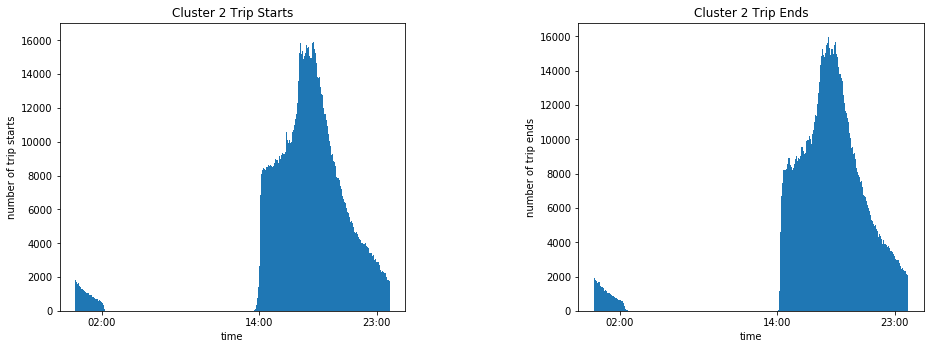

In [35]:
# Histogram of Cluster 2 to confirm its time range and compare it to the time range of cluster 0.

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.hist(cdata3[cdata3['cluster']==2]['start'],bins=1000);
ax1.set_title('Cluster 2 Trip Starts')
ax1.set_xticks(['02:00','14:00', '23:00']) 
ax1.set_ylabel('number of trip starts')

ax2.hist(cdata3[cdata3['cluster']==2]['end'],bins=1000);
ax2.set_title('Cluster 2 Trip Ends')
ax2.set_xticks(['02:00','14:00', '23:00']) 
ax2.set_ylabel('number of trip ends')

plt.subplots_adjust(top=2, bottom=1, left=1, right=3, hspace=0.5, wspace=0.5)

In [36]:
# Seven Clusters - Second Elbow point on SS curve.

In [37]:
# Frequency calculation for trip plotting.

n7freq0=tripfreq(cdata7[cdata7['cluster']==0])
n7freq1=tripfreq(cdata7[cdata7['cluster']==1])
n7freq2=tripfreq(cdata7[cdata7['cluster']==2])
n7freq3=tripfreq(cdata7[cdata7['cluster']==3])
n7freq4=tripfreq(cdata7[cdata7['cluster']==4])
n7freq5=tripfreq(cdata7[cdata7['cluster']==5])
n7freq6=tripfreq(cdata7[cdata7['cluster']==6])

In [38]:
# Run the clusterdescribe function.

clusterdescribe(7,cdata7)


Cluster Number 0.
minimum age is 16.0.
mean age is 39.1.
maximum age is 80.0.

minimum start time is 15:09:25.
maximum start time is 20:04:07.

minimum end time is 15:35:21.
maximum end time is 20:29:49.

the number of males is 2004786.
the number of Subscriber is 2004786.

Cluster Number 1.
minimum age is 16.0.
mean age is 39.9.
maximum age is 80.0.

minimum start time is 02:48:50.
maximum start time is 11:06:20.

minimum end time is 03:11:53.
maximum end time is 11:34:14.

the number of males is 1671700.
the number of Subscriber is 1653487.
the number of Customer is 18213.

Cluster Number 2.
minimum age is 16.0.
mean age is 38.0.
maximum age is 80.0.

minimum start time is 00:00:00.
maximum start time is 23:59:59.

minimum end time is 00:00:00.
maximum end time is 23:59:59.

the number of females is 1038937.
the number of Subscriber is 1038937.

Cluster Number 3.
minimum age is 16.0.
mean age is 38.6.
maximum age is 80.0.

minimum start time is 01:44:33.
maximum start time is 14:04:

()

In [39]:
# gmap plotting of trips - 200 most frequently taken trips in each cluster will be plotted in a different file.

tripfreqmap(n7freq0,dataset, n7freq0.iloc[199,1], 'n7c0top200.html')
os.system('n7c0top200.html')

tripfreqmap(n7freq1,dataset, n7freq1.iloc[199,1], 'n7c1top200.html')
os.system('n7c1top200.html')

tripfreqmap(n7freq2,dataset, n7freq2.iloc[199,1], 'n7c2top200.html')
os.system('n7c2top200.html')

tripfreqmap(n7freq3,dataset, n7freq3.iloc[199,1], 'n7c3top200.html')
os.system('n7c3top200.html')

tripfreqmap(n7freq4,dataset, n7freq4.iloc[199,1], 'n7c4top200.html')
os.system('n7c4top200.html')

tripfreqmap(n7freq5,dataset, n7freq5.iloc[199,1], 'n7c5top200.html')
os.system('n7c5top200.html')

tripfreqmap(n7freq6,dataset, n7freq6.iloc[199,1], 'n7c6top200.html')
os.system('n7c6top200.html')

1

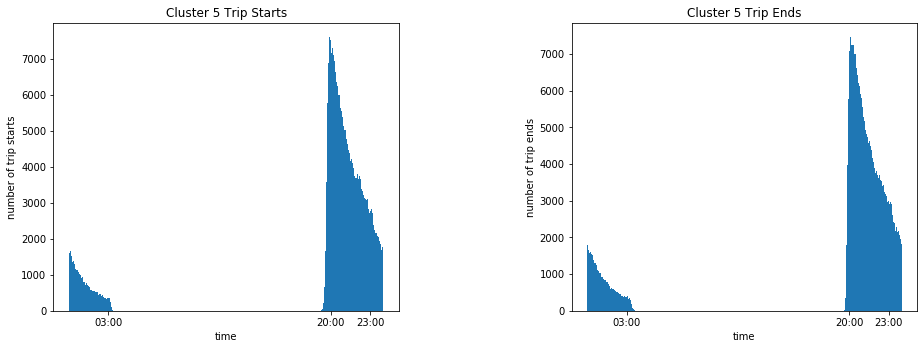

In [40]:
# Histogram of Cluster 5 to confirm its time range and compare it to the time range of Cluster 0, Cluster 4 and Cluster 1.

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.hist(cdata7[cdata7['cluster']==5]['start'],bins=1000);
ax1.set_title('Cluster 5 Trip Starts')
ax1.set_xticks(['03:00','20:00', '23:00']) 
ax1.set_ylabel('number of trip starts')

ax2.hist(cdata7[cdata7['cluster']==5]['end'],bins=1000);
ax2.set_title('Cluster 5 Trip Ends')
ax2.set_xticks(['03:00','20:00', '23:00']) 
ax2.set_ylabel('number of trip ends')

plt.subplots_adjust(top=2, bottom=1, left=1, right=3, hspace=0.5, wspace=0.5)

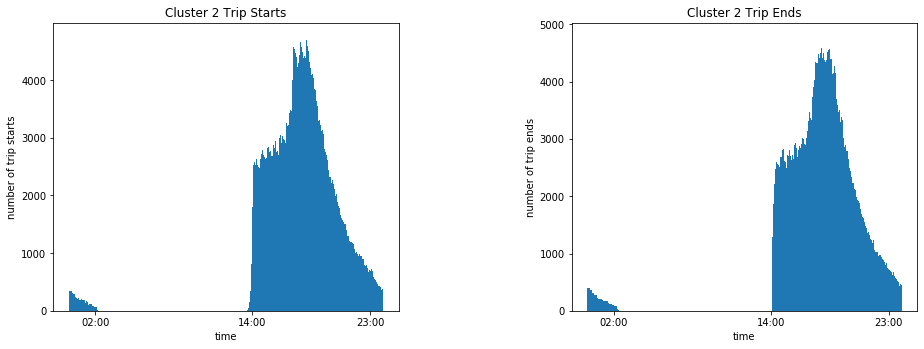

In [41]:
# Histogram of Cluster 2 to confirm its time range and compare it to the time range of Cluster 3 "Subscribers".

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.hist(cdata7[cdata7['cluster']==2]['start'],bins=1000);
ax1.set_title('Cluster 2 Trip Starts')
ax1.set_xticks(['02:00','14:00', '23:00']) 
ax1.set_ylabel('number of trip starts')

ax2.hist(cdata7[cdata7['cluster']==2]['end'],bins=1000);
ax2.set_title('Cluster 2 Trip Ends')
ax2.set_xticks(['02:00','14:00', '23:00']) 
ax2.set_ylabel('number of trip ends')

plt.subplots_adjust(top=2, bottom=1, left=1, right=3, hspace=0.5, wspace=0.5)

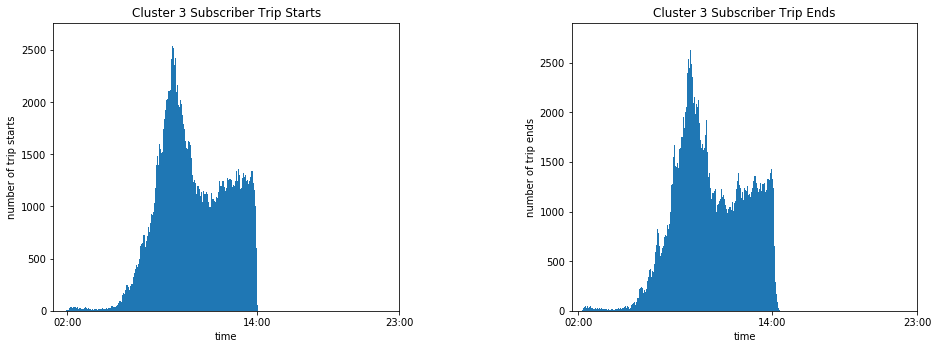

In [43]:
# Histogram of Cluster 3 "Subscribers".

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.hist(cdata7[(cdata7['cluster']==3) & (cdata7['usertype']=='Subscriber')]['start'],bins=1000);
ax1.set_title('Cluster 3 Subscriber Trip Starts')
ax1.set_xticks(['02:00','14:00', '23:00']) 
ax1.set_ylabel('number of trip starts')

ax2.hist(cdata7[(cdata7['cluster']==3) & (cdata7['usertype']=='Subscriber')]['end'],bins=1000);
ax2.set_title('Cluster 3 Subscriber Trip Ends')
ax2.set_xticks(['02:00','14:00', '23:00']) 
ax2.set_ylabel('number of trip ends')

plt.subplots_adjust(top=2, bottom=1, left=1, right=3, hspace=0.5, wspace=0.5)

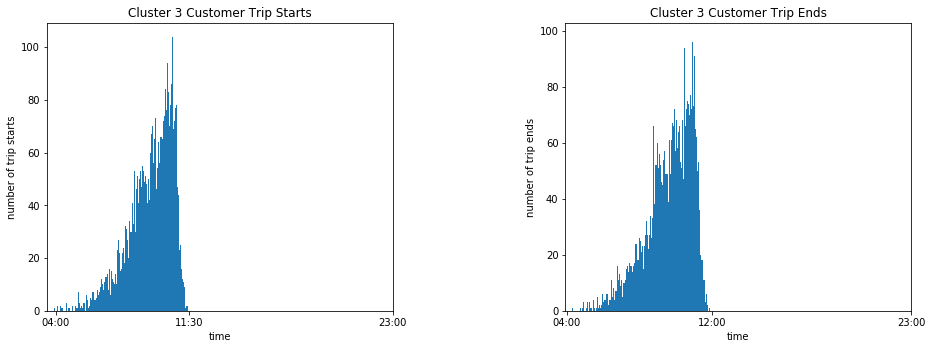

In [42]:
# Histogram of Cluster 3 "Customers". 

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.hist(cdata7[(cdata7['cluster']==3) & (cdata7['usertype']=='Customer')]['start'],bins=1000);
ax1.set_title('Cluster 3 Customer Trip Starts')
ax1.set_xticks(['04:00','11:30', '23:00']) 
ax1.set_ylabel('number of trip starts')

ax2.hist(cdata7[(cdata7['cluster']==3) & (cdata7['usertype']=='Customer')]['end'],bins=1000);
ax2.set_title('Cluster 3 Customer Trip Ends')
ax2.set_xticks(['04:00','12:00', '23:00']) 
ax2.set_ylabel('number of trip ends')

plt.subplots_adjust(top=2, bottom=1, left=1, right=3, hspace=0.5, wspace=0.5)

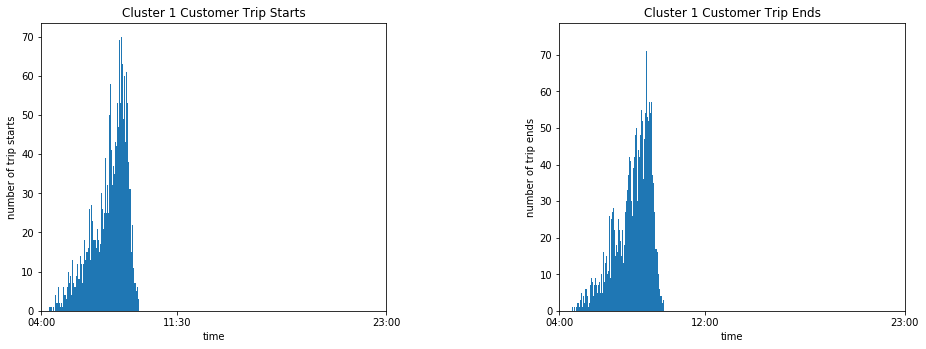

In [44]:
# Histogram of Cluster 1 "Customers".

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.hist(cdata7[(cdata7['cluster']==1) & (cdata7['usertype']=='Customer')]['start'],bins=1000);
ax1.set_title('Cluster 1 Customer Trip Starts')
ax1.set_xticks(['04:00','11:30', '23:00']) 
ax1.set_ylabel('number of trip starts')

ax2.hist(cdata7[(cdata7['cluster']==1) & (cdata7['usertype']=='Customer')]['end'],bins=1000);
ax2.set_title('Cluster 1 Customer Trip Ends')
ax2.set_xticks(['04:00','12:00', '23:00']) 
ax2.set_ylabel('number of trip ends')

plt.subplots_adjust(top=2, bottom=1, left=1, right=3, hspace=0.5, wspace=0.5)

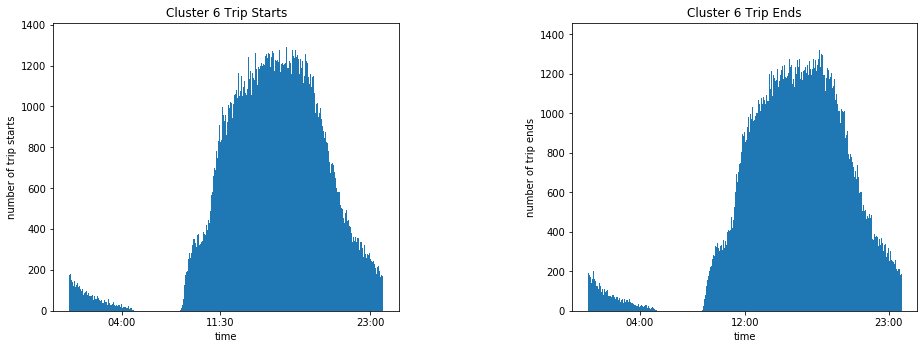

In [45]:
# Histogram of Cluster 6 to confirm its time range.

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.hist(cdata7[cdata7['cluster']==6]['start'],bins=1000);
ax1.set_title('Cluster 6 Trip Starts')
ax1.set_xticks(['04:00','11:30', '23:00']) 
ax1.set_ylabel('number of trip starts')

ax2.hist(cdata7[cdata7['cluster']==6]['end'],bins=1000);
ax2.set_title('Cluster 6 Trip Ends')
ax2.set_xticks(['04:00','12:00', '23:00']) 
ax2.set_ylabel('number of trip ends')

plt.subplots_adjust(top=2, bottom=1, left=1, right=3, hspace=0.5, wspace=0.5)

In [46]:
# 10 Clusters - at this point and beyond the curve is almost a straight line.

In [47]:
# Frequency calculation for trip plotting.

n10freq0=tripfreq(cdata10[cdata10['cluster']==0])
n10freq1=tripfreq(cdata10[cdata10['cluster']==1])
n10freq2=tripfreq(cdata10[cdata10['cluster']==2])
n10freq3=tripfreq(cdata10[cdata10['cluster']==3])
n10freq4=tripfreq(cdata10[cdata10['cluster']==4])
n10freq5=tripfreq(cdata10[cdata10['cluster']==5])
n10freq6=tripfreq(cdata10[cdata10['cluster']==6])
n10freq7=tripfreq(cdata10[cdata10['cluster']==7])
n10freq8=tripfreq(cdata10[cdata10['cluster']==8])
n10freq9=tripfreq(cdata10[cdata10['cluster']==9])

In [48]:
# Run the clusterdescribe function.

clusterdescribe(10,cdata10)


Cluster Number 0.
minimum age is 16.0.
mean age is 36.1.
maximum age is 80.0.

minimum start time is 00:00:00.
maximum start time is 23:59:59.

minimum end time is 00:00:00.
maximum end time is 23:59:59.

the number of males is 880478.
the number of Subscriber is 880478.

Cluster Number 1.
minimum age is 16.0.
mean age is 40.3.
maximum age is 80.0.

minimum start time is 10:35:01.
maximum start time is 15:41:51.

minimum end time is 11:01:58.
maximum end time is 16:09:12.

the number of males is 1365189.
the number of Subscriber is 1365189.

Cluster Number 2.
minimum age is 16.0.
mean age is 40.0.
maximum age is 80.0.

minimum start time is 02:48:50.
maximum start time is 11:05:59.

minimum end time is 03:11:53.
maximum end time is 11:34:14.

the number of males is 1653192.
the number of Subscriber is 1653058.
the number of Customer is 134.

Cluster Number 3.
minimum age is 16.0.
mean age is 36.1.
maximum age is 80.0.

minimum start time is 00:00:00.
maximum start time is 23:59:59.

m

()

In [49]:
# gmap plotting of trips - 200 most frequently taken trips in each cluster.

tripfreqmap(n10freq0,dataset, n10freq0.iloc[199,1], 'n10c0top200.html')
os.system('n10c0top200.html')

tripfreqmap(n10freq1,dataset, n10freq1.iloc[199,1], 'n10c1top200.html')
os.system('n10c1top200.html')

tripfreqmap(n10freq2,dataset, n10freq2.iloc[199,1], 'n10c2top200.html')
os.system('n10c2top200.html')

tripfreqmap(n10freq3,dataset, n10freq3.iloc[199,1], 'n10c3top200.html')
os.system('n10c3top200.html')

tripfreqmap(n10freq4,dataset, n10freq4.iloc[199,1], 'n10c4top200.html')
os.system('n10c4top200.html')

tripfreqmap(n10freq5,dataset, n10freq5.iloc[199,1], 'n10c5top200.html')
os.system('n10c5top200.html')

tripfreqmap(n10freq6,dataset, n10freq6.iloc[199,1], 'n10c6top200.html')
os.system('n10c6top200.html')

tripfreqmap(n10freq7,dataset, n10freq7.iloc[199,1], 'n10c7top200.html')
os.system('n10c7top200.html')

tripfreqmap(n10freq8,dataset, n10freq8.iloc[199,1], 'n10c8top200.html')
os.system('n10c8top200.html')

tripfreqmap(n10freq9,dataset, n10freq9.iloc[199,1], 'n10c9top200.html')
os.system('n10c9to200.html')

1

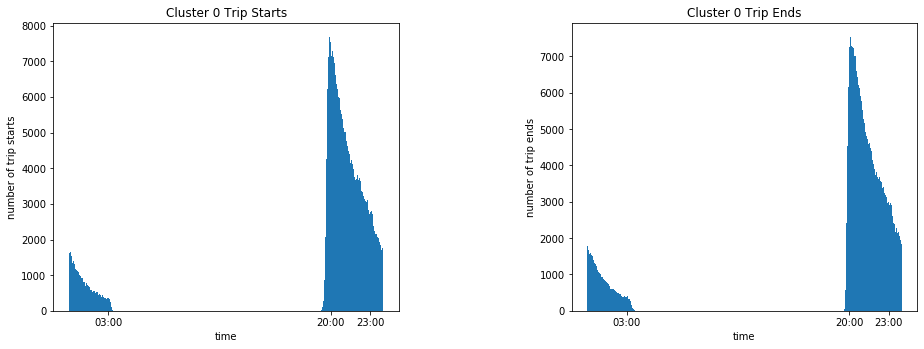

In [50]:
# Histogram of Cluster 0 to confirm its time range.

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.hist(cdata10[cdata10['cluster']==0]['start'],bins=1000);
ax1.set_title('Cluster 0 Trip Starts')
ax1.set_xticks(['03:00','20:00', '23:00']) 
ax1.set_ylabel('number of trip starts')

ax2.hist(cdata10[cdata10['cluster']==0]['end'],bins=1000);
ax2.set_title('Cluster 0 Trip Ends')
ax2.set_xticks(['03:00','20:00', '23:00']) 
ax2.set_ylabel('number of trip ends')

plt.subplots_adjust(top=2, bottom=1, left=1, right=3, hspace=0.5, wspace=0.5)

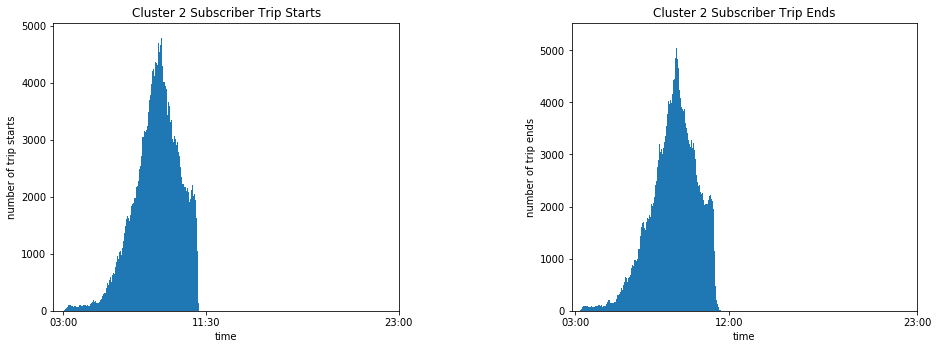

In [51]:
# Histogram of Cluster 2 Subscribers.

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.hist(cdata10[(cdata10['cluster']==2) & (cdata10['usertype']=='Subscriber')]['start'],bins=1000);
ax1.set_title('Cluster 2 Subscriber Trip Starts')
ax1.set_xticks(['03:00','11:30', '23:00']) 
ax1.set_ylabel('number of trip starts')

ax2.hist(cdata10[(cdata10['cluster']==2) & (cdata10['usertype']=='Subscriber')]['end'],bins=1000);
ax2.set_title('Cluster 2 Subscriber Trip Ends')
ax2.set_xticks(['03:00','12:00', '23:00']) 
ax2.set_ylabel('number of trip ends')

plt.subplots_adjust(top=2, bottom=1, left=1, right=3, hspace=0.5, wspace=0.5)

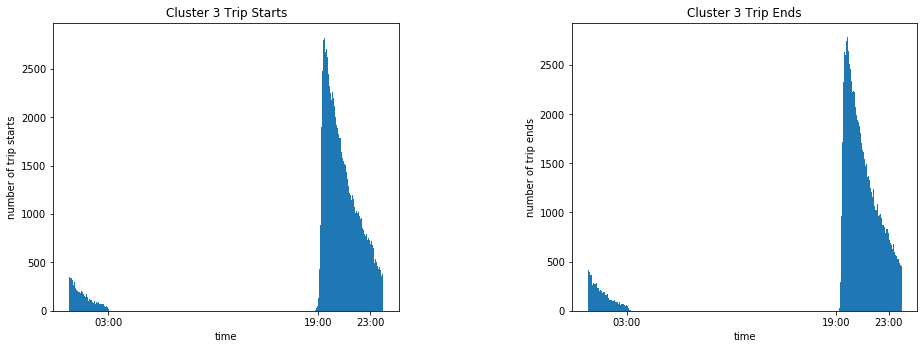

In [52]:
# Histogram of Cluster 3 to confirm its time range.

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.hist(cdata10[cdata10['cluster']==3]['start'],bins=1000);
ax1.set_title('Cluster 3 Trip Starts')
ax1.set_xticks(['03:00','19:00', '23:00']) 
ax1.set_ylabel('number of trip starts')

ax2.hist(cdata10[cdata10['cluster']==3]['end'],bins=1000);
ax2.set_title('Cluster 3 Trip Ends')
ax2.set_xticks(['03:00','19:00', '23:00']) 
ax2.set_ylabel('number of trip ends')

plt.subplots_adjust(top=2, bottom=1, left=1, right=3, hspace=0.5, wspace=0.5)

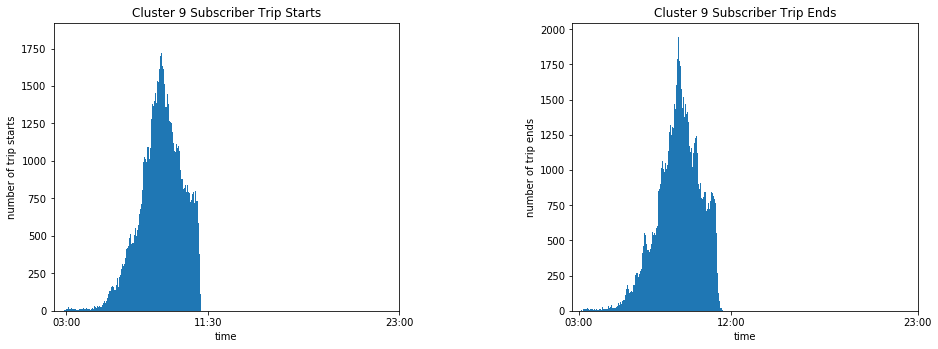

In [53]:
# Histogram of Cluster 9 "Subscribers"

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.hist(cdata10[(cdata10['cluster']==9) & (cdata10['usertype']=='Subscriber')]['start'],bins=1000);
ax1.set_title('Cluster 9 Subscriber Trip Starts')
ax1.set_xticks(['03:00','11:30', '23:00']) 
ax1.set_ylabel('number of trip starts')

ax2.hist(cdata10[(cdata10['cluster']==9) & (cdata10['usertype']=='Subscriber')]['end'],bins=1000);
ax2.set_title('Cluster 9 Subscriber Trip Ends')
ax2.set_xticks(['03:00','12:00', '23:00']) 
ax2.set_ylabel('number of trip ends')

plt.subplots_adjust(top=2, bottom=1, left=1, right=3, hspace=0.5, wspace=0.5)

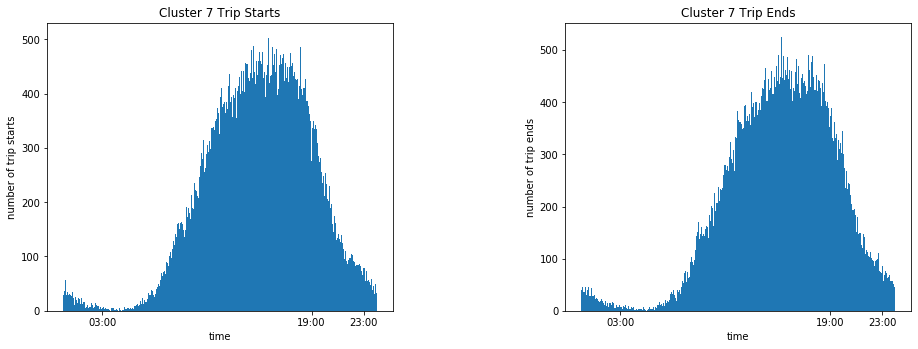

In [54]:
# Histogram of Cluster 7.

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.hist(cdata10[cdata10['cluster']==7]['start'],bins=1000);
ax1.set_title('Cluster 7 Trip Starts')
ax1.set_xticks(['03:00','19:00', '23:00']) 
ax1.set_ylabel('number of trip starts')

ax2.hist(cdata10[cdata10['cluster']==7]['end'],bins=1000);
ax2.set_title('Cluster 7 Trip Ends')
ax2.set_xticks(['03:00','19:00', '23:00']) 
ax2.set_ylabel('number of trip ends')

plt.subplots_adjust(top=2, bottom=1, left=1, right=3, hspace=0.5, wspace=0.5)

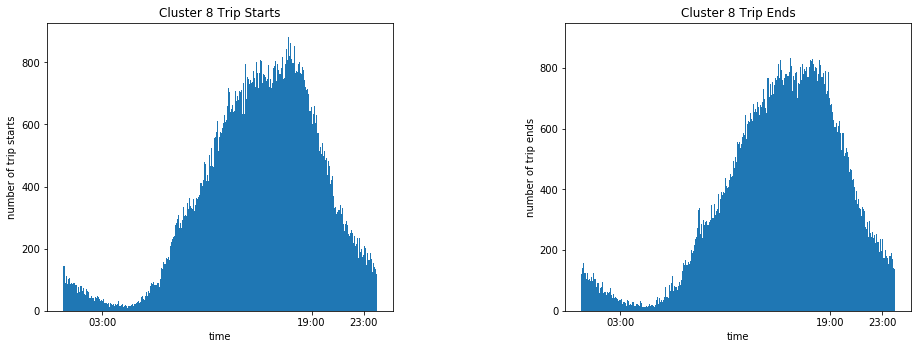

In [55]:
# Histogram of Cluster 8.

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

ax1.hist(cdata10[cdata10['cluster']==8]['start'],bins=1000);
ax1.set_title('Cluster 8 Trip Starts')
ax1.set_xticks(['03:00','19:00', '23:00']) 
ax1.set_ylabel('number of trip starts')

ax2.hist(cdata10[cdata10['cluster']==8]['end'],bins=1000);
ax2.set_title('Cluster 8 Trip Ends')
ax2.set_xticks(['03:00','19:00', '23:00']) 
ax2.set_ylabel('number of trip ends')

plt.subplots_adjust(top=2, bottom=1, left=1, right=3, hspace=0.5, wspace=0.5)